# Network inference from time series of categorical variables

In [1]:
import sys,os
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
%matplotlib inline

import inference

In [2]:
# setting parameter:
np.random.seed(1)

n = 20 # number of positions
m = 5 # number of values at each position
l = int(2*((n*m)**2)) # number of samples
g = 2.

In [3]:
w0 = inference.generate_interactions(n,m,g)

In [4]:
s = inference.generate_sequences(w0,n,m,l)

In [5]:
def itab(n,m):    
    i1 = np.zeros(n)
    i2 = np.zeros(n)
    for i in range(n):
        i1[i] = i*m
        i2[i] = (i+1)*m

    return i1.astype(int),i2.astype(int)

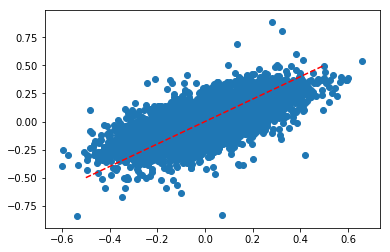

In [12]:
nloop = 20
i1tab,i2tab = itab(n,m)

x = s[:-1]
y = s[1:]

s_av = np.mean(x,axis=0)
ds = x - s_av
c = np.cov(ds,rowvar=False,bias=True)
#print(c)

c_inv = linalg.pinv(c,rcond=1e-15)
#print(c_inv)

nm = n*m
wini = np.random.normal(0.0,1./np.sqrt(nm),size=(nm,nm))
#print(w)

w_infer = np.zeros((nm,nm))

for i in range(n):
    #print(i)
    i1,i2 = i1tab[i],i2tab[i]

    w = wini[i1:i2,:].copy()
    cost = np.full(nloop,100.)
    for iloop in range(1,nloop):        
        h = np.dot(x,w.T)
        p = np.exp(h)
        p_sum = p.sum(axis=1)
        
        p /= p_sum[:,np.newaxis]

        # stopping criterion
        cost[iloop] = ((y[:,i1:i2] - p[:,:])**2).mean()
        if cost[iloop] >= cost[iloop-1]: break  
                        
        h += y[:,i1:i2] - p
                
        h_av = h.mean(axis=0)
        dh = h - h_av
        dhds = dh[:,:,np.newaxis]*ds[:,np.newaxis,:]
        dhds_av = dhds.mean(axis=0)

        w = np.dot(dhds_av,c_inv)

    w_infer[i1:i2,:] = w     

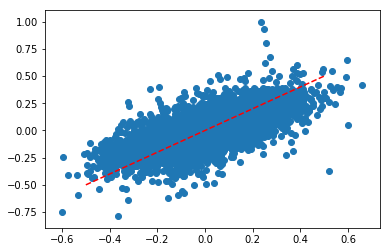

In [11]:
plt.scatter(w0,w_infer)
plt.plot([-0.5,0.5],[-0.5,0.5],'r--')   